# Age Estimation task

## Imports

In [28]:
import numpy as np
import pandas as pd

import scipy
from scipy.stats import skew, kurtosis

import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import seaborn as sns

import librosa
import librosa.display

import warnings
warnings.filterwarnings("ignore")

# %matplotlib widget

## Constants

In [29]:
FILE_DEVELOPMENT = "Dataset/development.csv"
FILE_EVALUATION = "Dataset/evaluation.csv"
AUDIOS_DEVELOPMENT = "Dataset/audios_development/"
AUDIOS_EVALUATION = "Dataset/audios_evaluation/"

precisionLog = {
    'mean_pitch':2, 
    'max_pitch':2, 
    'min_pitch':3, 
    'jitter':2, 
    'shimmer':2, 
    'energy':1, 
    'zcr_mean':2, 
    'spectral_centroid_mean':2,
    'tempo':3,
    'hnr':0
}

precisionLinear = {
    'mean_pitch':-1, 
    'max_pitch':-2, 
    'min_pitch':0, 
    'jitter':3, 
    'shimmer':3, 
    'energy':3, 
    'zcr_mean':2, 
    'spectral_centroid_mean':-2,
    'tempo':3,
    'hnr':0
}

## Data reading

In [30]:
dev_original_df = pd.read_csv(FILE_DEVELOPMENT, header=0, index_col=0)
eval_original_df = pd.read_csv(FILE_EVALUATION, header=0, index_col=0)

audio_dev = os.listdir(AUDIOS_DEVELOPMENT)
audio_eval = os.listdir(AUDIOS_EVALUATION)

In [31]:
print(audio_dev[:5])
print(audio_eval[:5])

['1.wav', '10.wav', '100.wav', '1000.wav', '1001.wav']
['1.wav', '10.wav', '100.wav', '101.wav', '102.wav']


Order audios by integers and increasing order

In [32]:
audio_dev.sort(key=lambda x: int(x.split('.')[0]))
audio_eval.sort(key=lambda x: int(x.split('.')[0]))

print(audio_dev[:5])
print(audio_eval[:5])

['1.wav', '2.wav', '3.wav', '4.wav', '5.wav']
['1.wav', '2.wav', '3.wav', '4.wav', '5.wav']


## Tabular Data Exploration

In [33]:
# display(dev_original_df.head())

display(f"Total number of nan in development: {dev_original_df.isna().sum().sum()}")
display(f"Total number of nan in evaluation: {eval_original_df.isna().sum().sum()}")

desc_dev_df = dev_original_df.describe()
desc_eval_df = eval_original_df.describe()

sampling_rate = dev_original_df['sampling_rate'].iloc[0]

# display(desc_dev_df.loc['std', 'sampling_rate'])
# display(desc_eval_df.loc['std', 'sampling_rate'])

dev_df = dev_original_df.drop('sampling_rate', axis=1)
eval_df = eval_original_df.drop('sampling_rate', axis=1)

ages_df = dev_df[['age']]
path_dev_df = dev_df[['path']]
path_eval_df = eval_df[['path']]

dev_df = dev_df.drop(['path'], axis=1)
eval_df = eval_df.drop('path', axis=1)

display(dev_df.head())
display(eval_df.head())

'Total number of nan in development: 0'

'Total number of nan in evaluation: 0'

,age,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,,,
0,24.0,female,arabic,1821.6906,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,[151.99908088],-123.999726,69,281,39,23.846893
1,22.5,female,hungarian,1297.8187,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,[129.19921875],-86.928478,69,281,21,19.388662
2,22.0,female,portuguese,1332.8524,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,[117.45383523],-98.450670,69,281,1,21.640998
3,22.0,female,english,1430.3499,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,[117.45383523],-56.459762,69,281,9,19.644127
4,22.0,male,dutch,1688.7234,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,[112.34714674],-80.349204,69,281,11,18.041905


,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,,
0,male,spanish,1056.91740,3945.1610,145.38750,0.022082,0.171076,0.003136,0.032963,1549.607050,[80.74951172],-116.662338,69,281,2,38.198503
1,male,xiang,1231.84570,3999.1720,145.56432,0.026571,0.132585,0.006783,0.123895,2344.817369,[89.10290948],-78.253824,69,281,27,29.605442
2,male,igbo,958.29065,3445.4490,145.67374,0.018044,0.096289,0.004478,0.089149,1939.574896,[123.046875],-71.630742,6,22,2,2.275556
3,female,spanish,1396.54170,3998.8948,145.41223,0.027290,0.088901,0.014893,0.097054,1832.059113,[123.046875],-101.533013,69,281,31,22.151837
4,male,spanish,1633.86770,3999.7632,145.36313,0.021621,0.103855,0.001369,0.140950,2534.611168,[112.34714674],-134.914070,69,281,35,22.430476


In [34]:
temp = dev_df['num_words'].value_counts()
display(temp)

et = dev_df['ethnicity'].value_counts()
et

num_words
69    1710
0      409
4      257
3      158
5      148
2       78
1       66
6       62
7       39
8        2
9        2
12       1
10       1
Name: count, dtype: int64

ethnicity
igbo        1081
english      579
arabic       102
mandarin      65
french        63
            ... 
hakka          1
malagasy       1
lingala        1
fang           1
rundi          1
Name: count, Length: 165, dtype: int64

## Preprocess tabular data

### Encoding

#### Ethnicity

In [35]:
def encode_english(X_df):
    X_copy = X_df.copy()

    X_copy['ethnicity'] = X_copy['ethnicity'].apply(lambda x: 1 if x == 'english' else 0)
    return X_copy

In [36]:
def encode_ethnicity(X_df, ethnie):
    etna = pd.DataFrame(1, columns=ethnie, index=X_df.index)

    aggregated_ethnicity_df = X_df.copy()
    aggregated_ethnicity_df.loc[~(aggregated_ethnicity_df['ethnicity'].isin(ethnie)), 'ethnicity'] = 'others'

    for etnia in ethnie:
        aggregated_ethnicity_df.loc[aggregated_ethnicity_df['ethnicity'] == etnia, etnia] = etna[etnia]

        # aggregated_ethnicity_df.loc[aggregated_ethnicity_df['ethnicity'] == etnia, etnia] = 1
        aggregated_ethnicity_df.loc[~(aggregated_ethnicity_df['ethnicity'] == etnia), etnia] = 0

    # encoded_ethnicity = pd.get_dummies(aggregated_ethnicity_df['ethnicity'], dtype=int)

    try:
        aggregated_ethnicity_df = aggregated_ethnicity_df.drop(columns=['ethnicity'], axis=1)
    except KeyError:
        pass

    return aggregated_ethnicity_df

In [37]:
enticity_df = dev_df['ethnicity'].value_counts().sort_values(ascending=False)

median_et = enticity_df.median()
display(enticity_df[enticity_df == 1].shape)
display(enticity_df.head(20))
display(enticity_df.tail(10))
# enticity_df[enticity_df > median_et].plot()

etnie_chosen = sorted(list(set(enticity_df[enticity_df > median_et].index)))
display(etnie_chosen)
display(etnie_chosen.__len__())

(58,)

ethnicity
igbo          1081
english        579
arabic         102
mandarin        65
french          63
korean          52
portuguese      48
russian         48
dutch           47
german          36
polish          34
italian         33
urhobo          32
japanese        27
ibibio          27
macedonian      26
farsi           23
cantonese       23
igala           22
amharic         20
Name: count, dtype: int64

ethnicity
faroese        1
nandi          1
nuer           1
dinka          1
mortlockese    1
hakka          1
malagasy       1
lingala        1
fang           1
rundi          1
Name: count, dtype: int64

['albanian',
 'amharic',
 'arabic',
 'armenian',
 'azerbaijani',
 'bambara',
 'belarusan',
 'bengali',
 'bosnian',
 'bulgarian',
 'cantonese',
 'catalan',
 'congolese',
 'croatian',
 'czech',
 'danish',
 'dari',
 'dutch',
 'english',
 'estonian',
 'fanti',
 'farsi',
 'fijian',
 'finnish',
 'french',
 'ga',
 'georgian',
 'german',
 'greek',
 'gujarati',
 'hausa',
 'hebrew',
 'hindi',
 'hungarian',
 'ibibio',
 'icelandic',
 'igala',
 'igbo',
 'ika',
 'indonesian',
 'italian',
 'japanese',
 'kambaata',
 'kazakh',
 'khmer',
 'kikuyu',
 'kiswahili',
 'korean',
 'krio',
 'kurdish',
 'lao',
 'latvian',
 'lithuanian',
 'macedonian',
 'malay',
 'malayalam',
 'mandarin',
 'marathi',
 'mende',
 'miskito',
 'mongolian',
 'nepali',
 'nigerian',
 'norwegian',
 'obudu',
 'oromo',
 'pashto',
 'polish',
 'portuguese',
 'pulaar',
 'punjabi',
 'romanian',
 'russian',
 'tiv',
 'urhobo',
 'yoruba']

76

#### Gender

In [38]:
def encode_gender_one_hot(X_df:pd.DataFrame):
    X_copy = X_df.copy()

    X_copy['male'] = (X_copy['gender'] == 'male').astype(int)
    X_copy['female'] = (X_copy['gender'].isin(['female','famale'])).astype(int)

    return X_copy.drop(columns='gender', axis=1)

In [39]:
GenderMapper = {
    'male': 1,
    'female': -1
}

def encode_gender(X_df:pd.DataFrame, mapper):
    encoded_df = X_df.copy()
    for gender, value in mapper.items():
        encoded_df.loc[encoded_df['gender'] == gender, 'gender'] = value

    encoded_df.loc[encoded_df['gender'] == 'famale', 'gender'] = -1

    encoded_df['gender'] = encoded_df['gender'].astype(float)
    return encoded_df

#### Tempo

In [40]:
# display(encoded_gender_etnicity_df['tempo'])

def encode_tempo(X_df):
    encoded_df = X_df.copy()
    encoded_df['tempo'] = encoded_df['tempo'].map(lambda x: float(x.strip('[').strip(']')))
    return encoded_df


#### Results

In [41]:
display(eval_df.loc[eval_df['ethnicity'].isin(etnie_chosen), 'ethnicity'].value_counts())

# FOR NOW, WE WILL DROP ETHNICITY #TODO:

# step1_dev_df = encode_ethnicity(dev_df, etnie_chosen)
# step1_eval_df = encode_ethnicity(eval_df, etnie_chosen)

step1_dev_df = encode_ethnicity(dev_df, etnie_chosen)
step1_eval_df = encode_ethnicity(eval_df, etnie_chosen)

# step1_dev_df = dev_df.copy()
# step1_eval_df = eval_df.copy()

# display(dev_df.head(5))
# display(eval_df.head(5))

# step1_eval_df = encode_ethnicity(eval_df, etnie_chosen)

# display(step1_dev_df.head())
# display(step1_eval_df.head())

# step1_eval_df['gender'].value_counts()

# step2_dev_df = encode_gender_one_hot(step1_dev_df)
# step2_eval_df = encode_gender_one_hot(step1_eval_df)

step2_dev_df = encode_gender(step1_dev_df, GenderMapper)
step2_eval_df = encode_gender(step1_eval_df, GenderMapper)

# display(step2_dev_df.head(5))
# display(step2_eval_df.head(5))

step3_dev_df = encode_tempo(step2_dev_df)
step3_eval_df = encode_tempo(step2_eval_df)

display(step3_dev_df.head(5))
# display(step3_eval_df.head(5))

# step3_dev_df = step3_dev_df.drop(columns=['ethnicity'], axis=1)
# step3_eval_df = step3_eval_df.drop(columns=['ethnicity'], axis=1)

# display(step3_dev_df.head(5))

# display(step3_eval_df[step3_eval_df['yoruba'] == 1])
# display(eval_df.loc[75, :])

display(step3_dev_df.describe())
display(step3_eval_df.describe())

ethnicity
igbo         232
yoruba         5
igala          4
ibibio         2
congolese      1
urhobo         1
nigerian       1
hausa          1
Name: count, dtype: int64

,age,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,...,pashto,polish,portuguese,pulaar,punjabi,romanian,russian,tiv,urhobo,yoruba
Id,,,,,,,,,,,,,,,,,,,,,
0,24.0,-1.0,1821.6906,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22.5,-1.0,1297.8187,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22.0,-1.0,1332.8524,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22.0,-1.0,1430.3499,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22.0,1.0,1688.7234,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,age,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,...,pashto,polish,portuguese,pulaar,punjabi,romanian,russian,tiv,urhobo,yoruba
count,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,...,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000
mean,27.897886,-0.001023,1189.536569,3779.570485,146.934930,0.021190,0.107741,0.005208,0.104774,2176.369847,...,0.003409,0.011592,0.016365,0.001023,0.003409,0.006819,0.016365,0.001364,0.010910,0.004091
std,13.093316,1.000170,414.193673,532.847869,3.757917,0.006626,0.029005,0.006074,0.051646,578.925294,...,0.058301,0.107060,0.126898,0.031971,0.058301,0.082309,0.126898,0.036911,0.103899,0.063844
min,6.000000,-1.000000,346.974330,935.515560,145.349140,0.007292,0.045205,0.000028,0.015947,692.116731,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,-1.000000,818.922360,3948.234400,145.419140,0.016734,0.087378,0.001960,0.060733,1740.756716,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,23.000000,-1.000000,1208.998300,3998.397200,145.622010,0.020525,0.104697,0.003716,0.098964,2150.814043,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,1.000000,1523.777700,3999.485400,146.820890,0.024558,0.124993,0.006338,0.139559,2566.190670,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,97.000000,1.000000,2724.892800,3999.792500,202.040700,0.096153,0.265167,0.129114,0.335976,4144.132595,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,...,pashto,polish,portuguese,pulaar,punjabi,romanian,russian,tiv,urhobo,yoruba
count,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,...,691.0,691.0,691.0,691.0,691.0,691.0,691.0,691.0,691.000000,691.000000
mean,0.137482,1191.041077,3832.214580,146.591685,0.021320,0.110438,0.005074,0.105111,2214.701841,126.437846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001447,0.007236
std,0.991222,379.826928,451.201809,3.212186,0.006399,0.029365,0.005430,0.050162,571.250581,33.134285,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038042,0.084817
min,-1.000000,419.396150,1151.012200,145.349230,0.009395,0.035001,0.000056,0.018496,803.534172,54.978391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
25%,-1.000000,865.617580,3955.649050,145.401825,0.017184,0.089501,0.001851,0.064549,1785.536118,103.359375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
50%,1.000000,1209.680400,3998.631300,145.529140,0.020670,0.106233,0.003582,0.098416,2174.406614,123.046875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
75%,1.000000,1487.326050,3999.521850,146.396920,0.024536,0.126537,0.006147,0.135834,2580.589333,143.554688,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
max,1.000000,2201.411000,3999.790800,186.688950,0.077450,0.246068,0.048074,0.335676,4753.076563,258.398438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000


### Behavior analysis and $log_{10}$ scaling

#### Insight

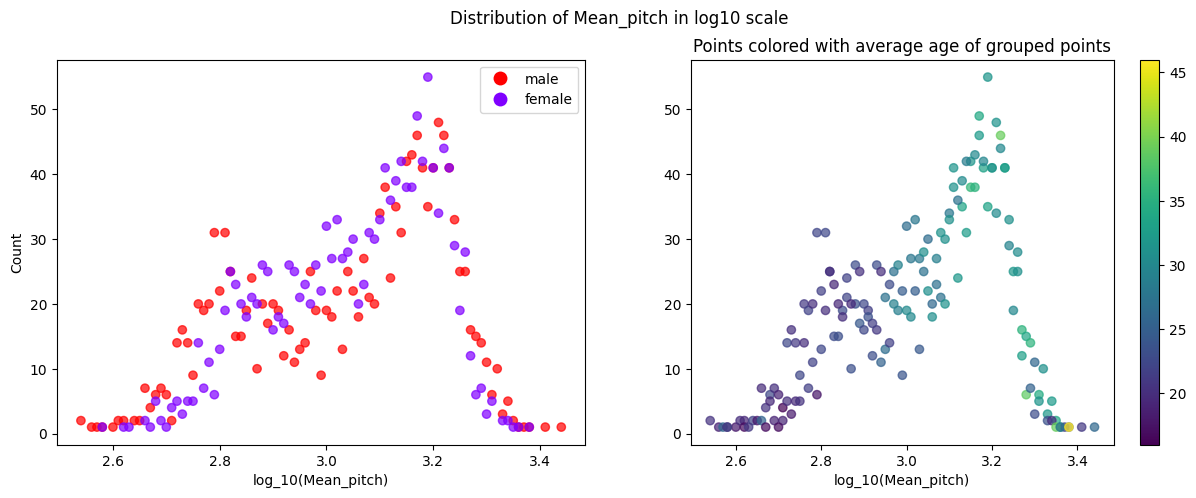

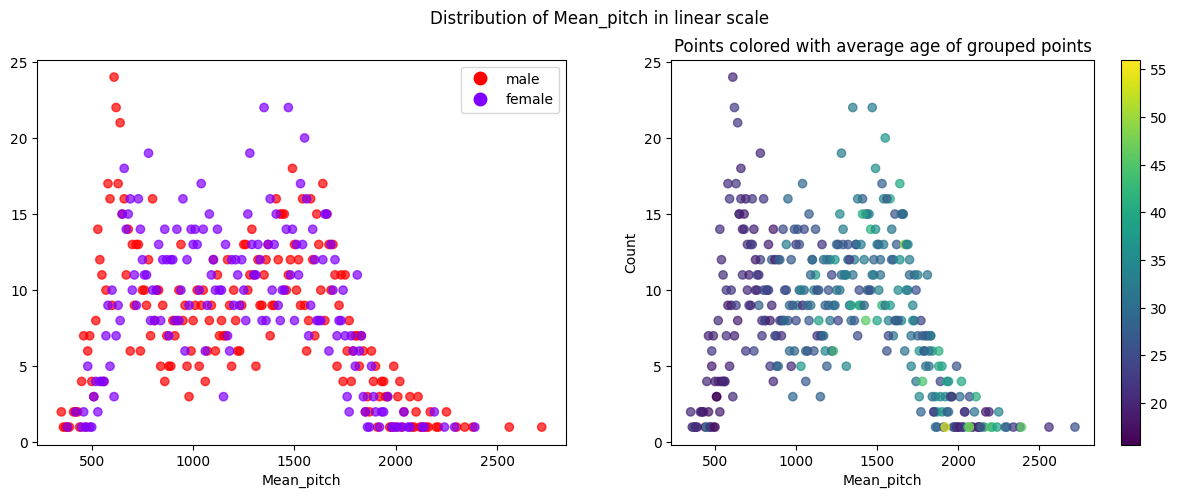

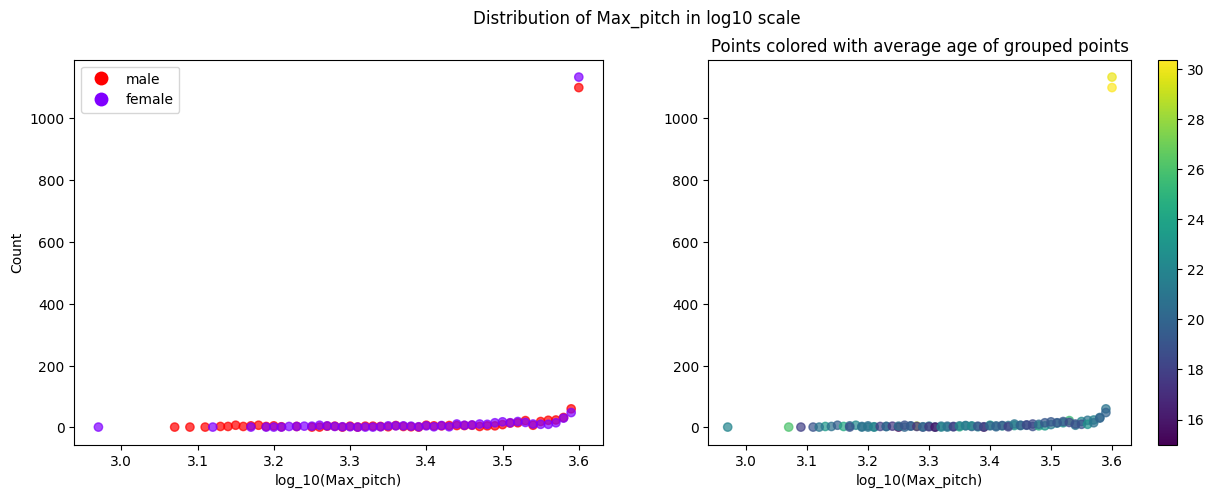

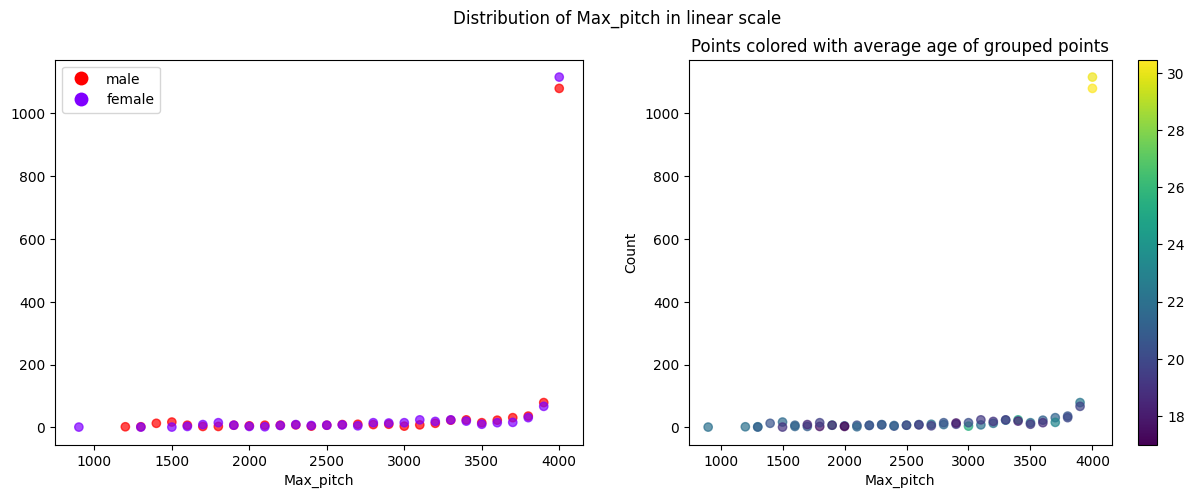

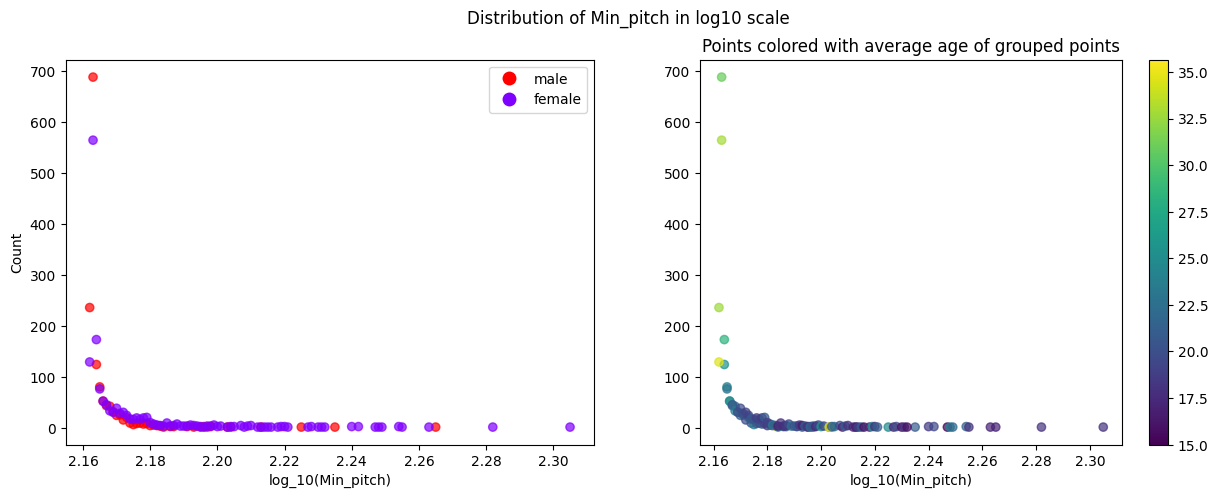

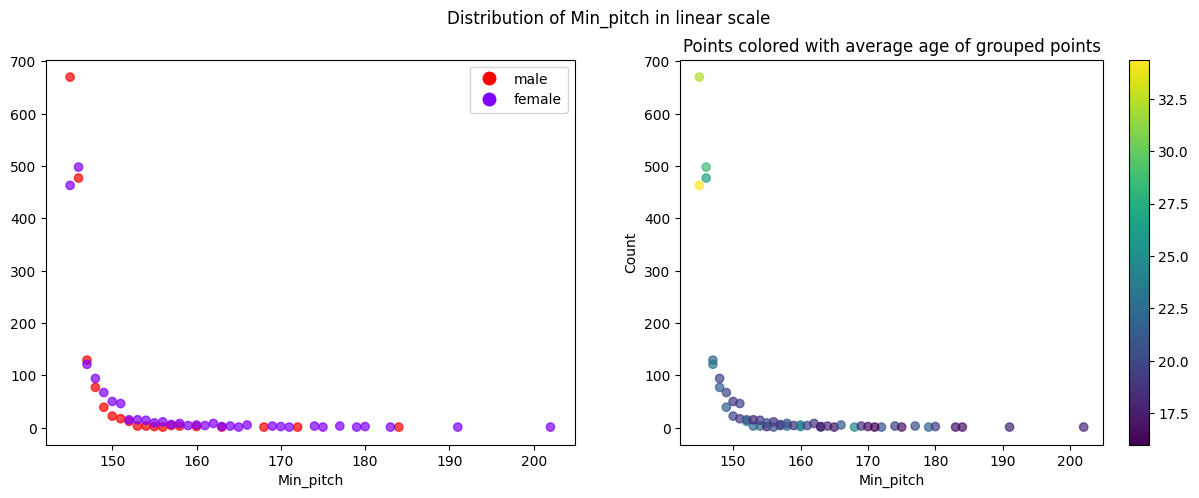

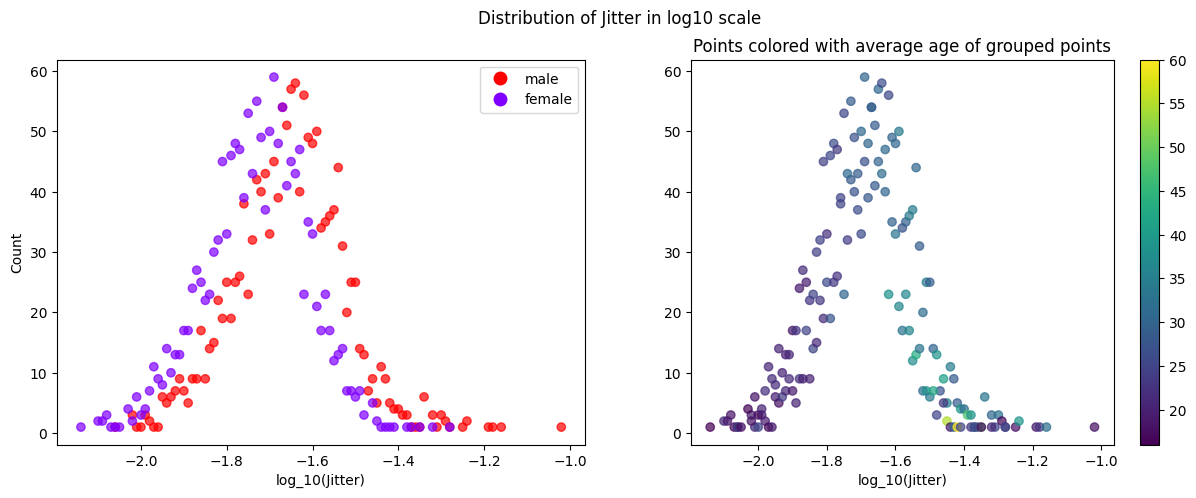

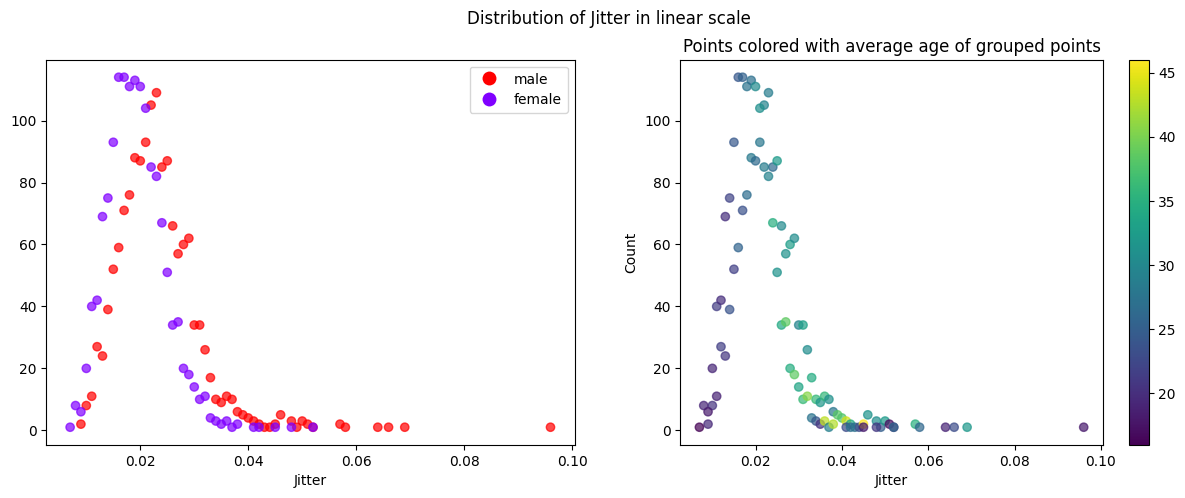

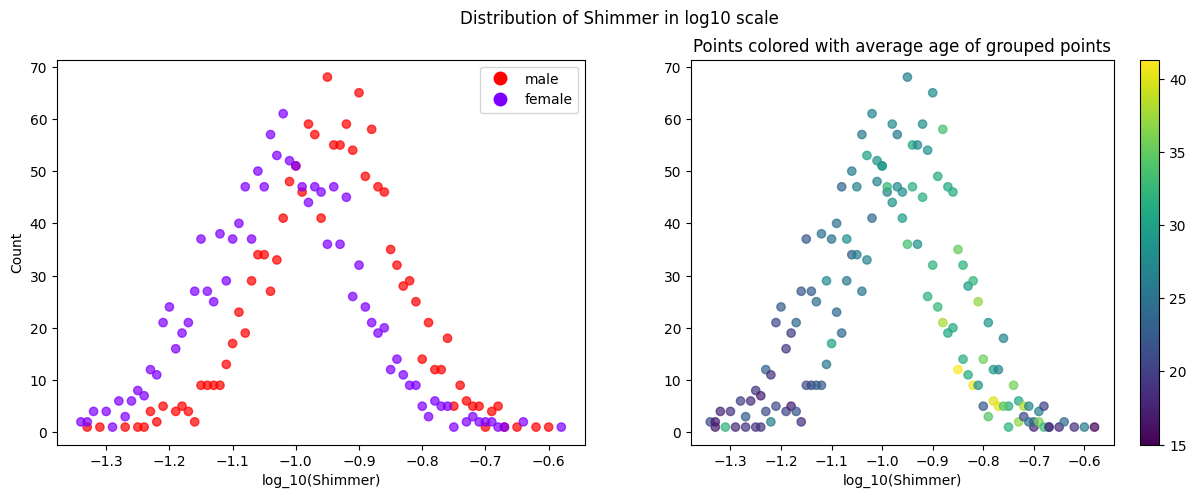

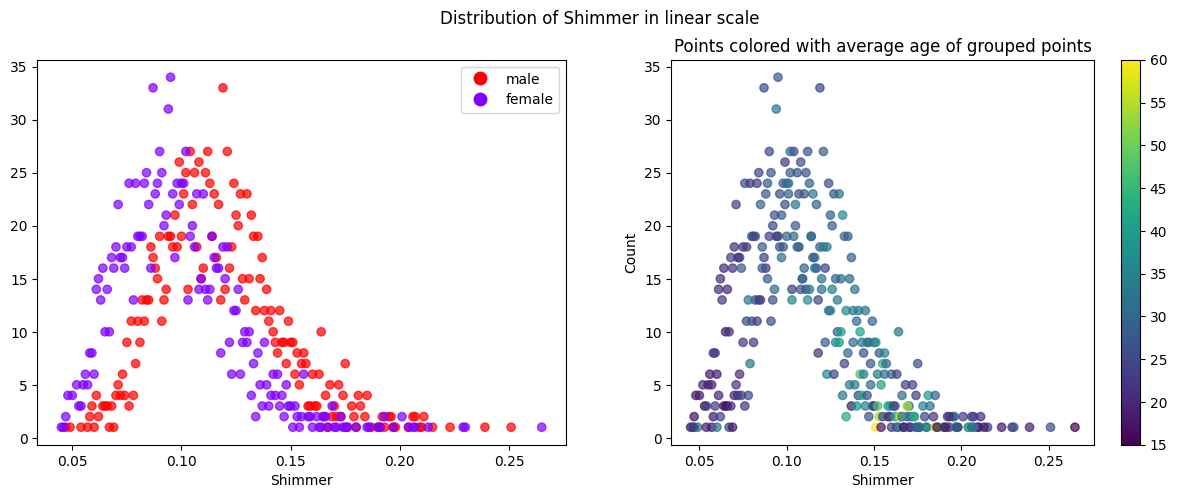

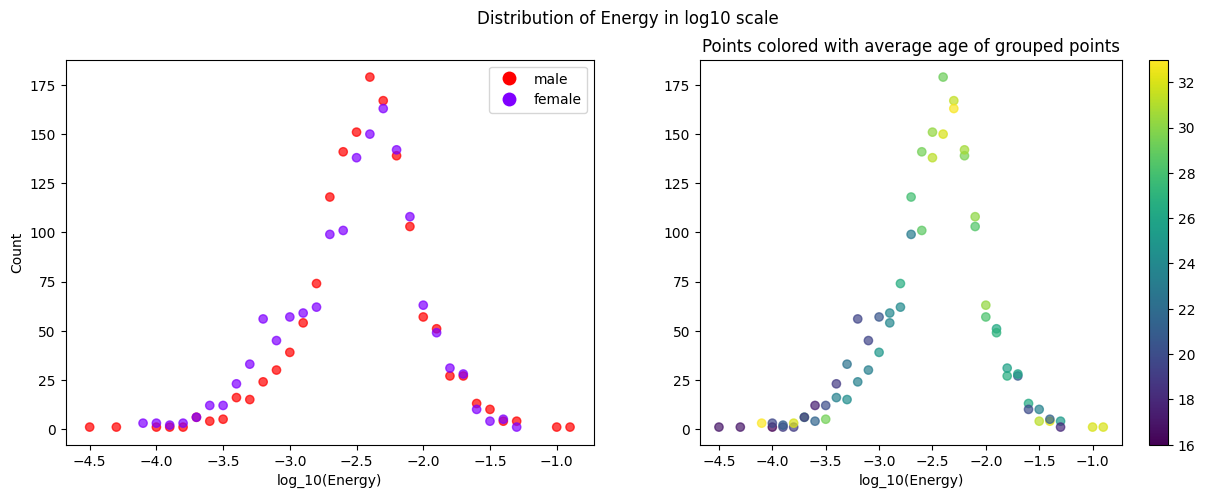

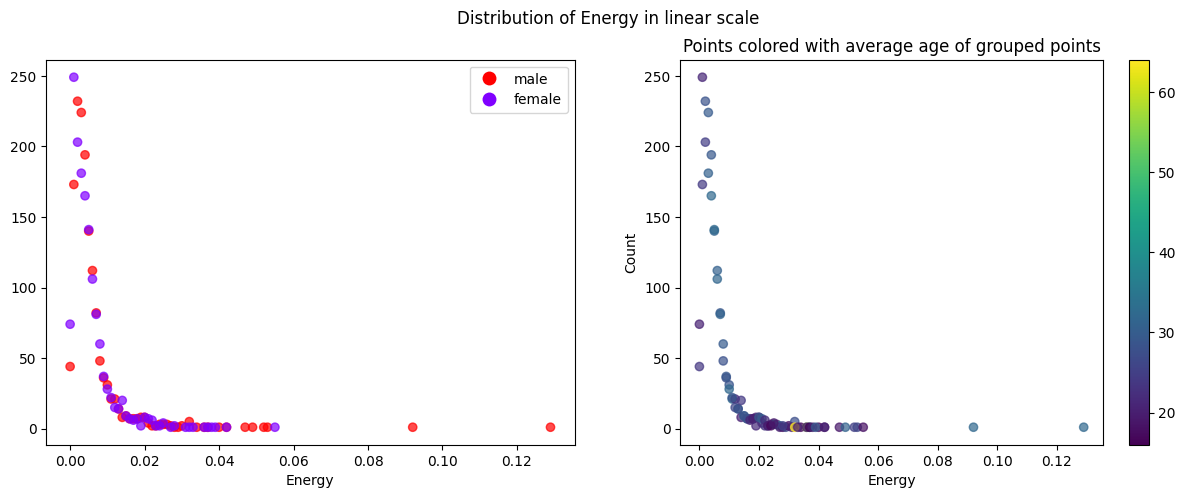

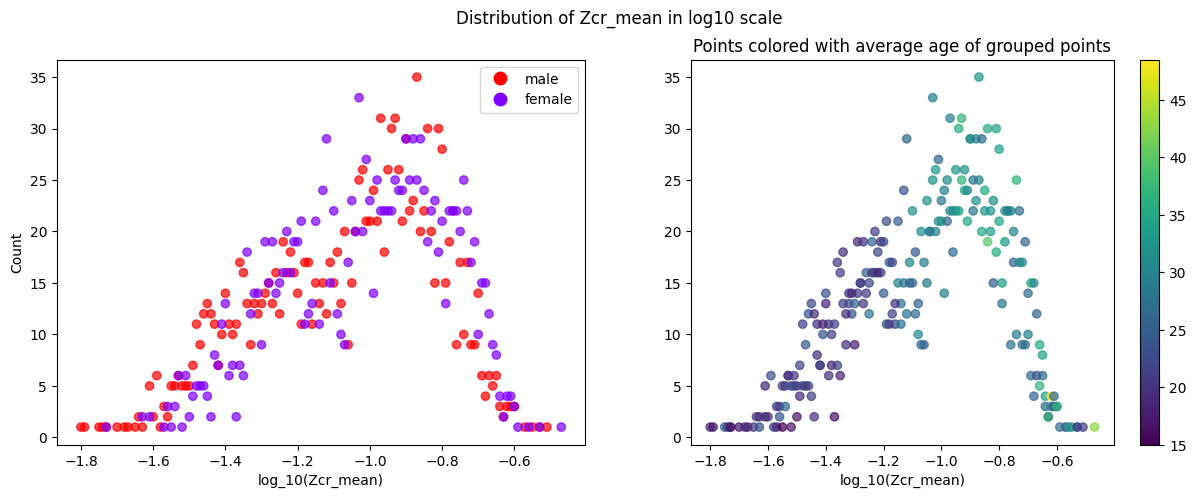

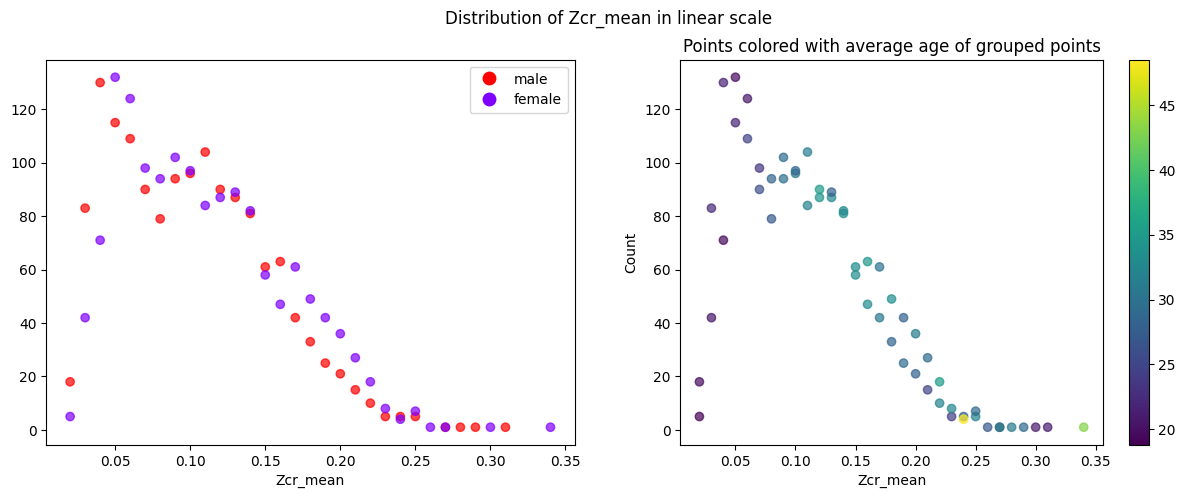

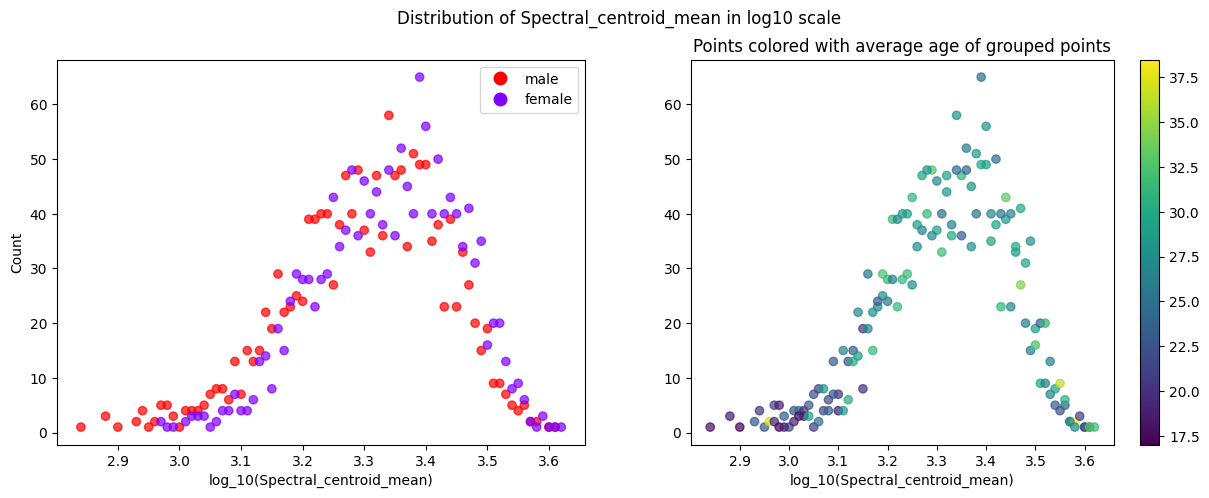

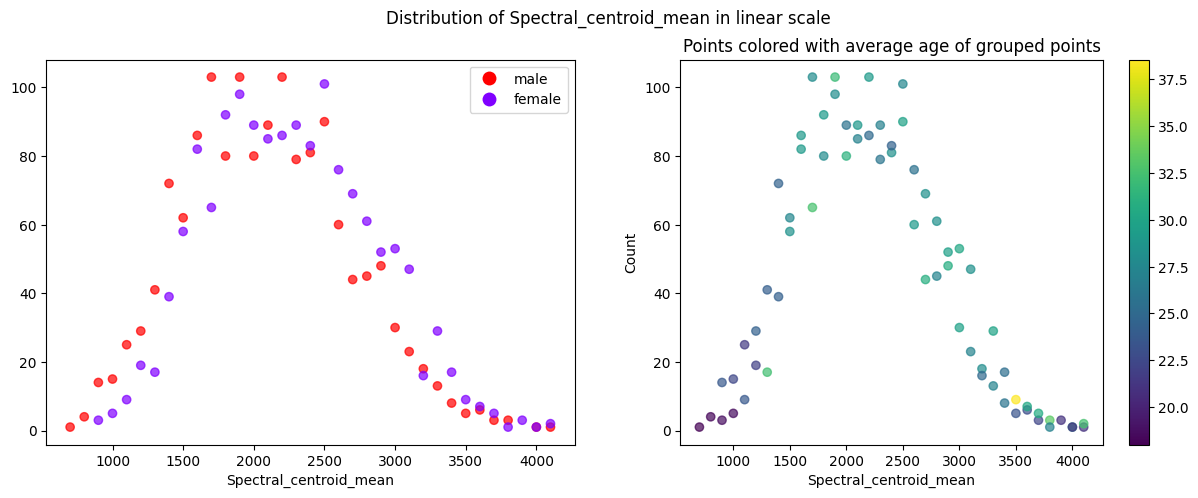

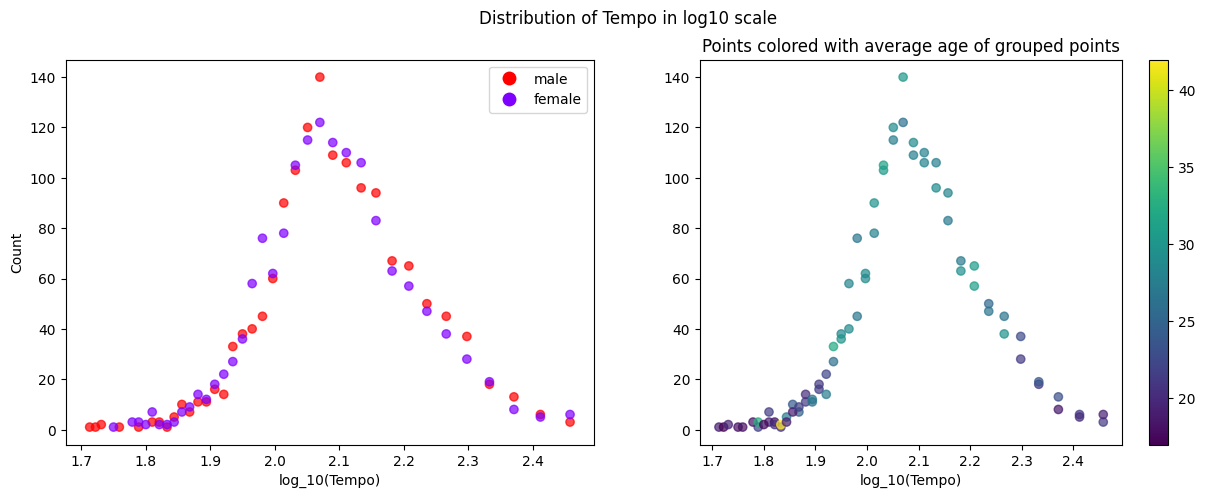

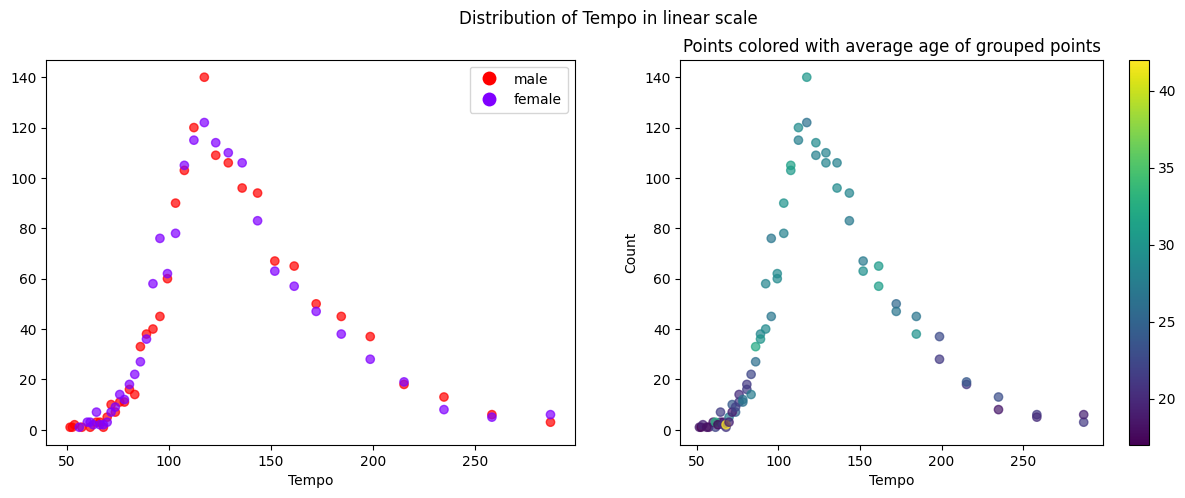

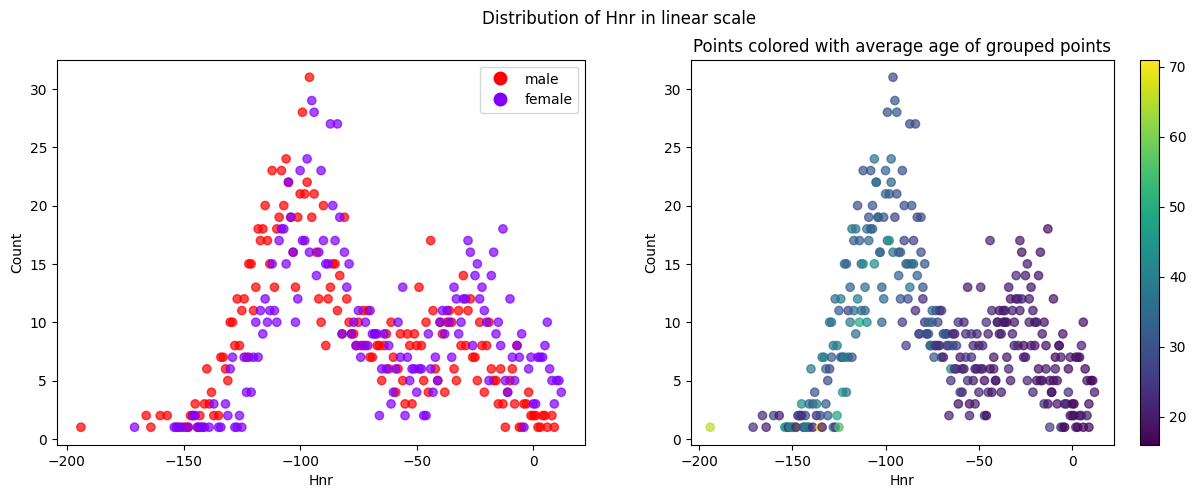

In [42]:
def create_colors(values:pd.Series, label:str, use_continous:bool=False, 
                  cmap_continuous = cm.viridis, cmap_discrete = cm.rainbow):
    if use_continous:
        cmap_ = cmap_continuous
        # Alternative normalization without iterquartile ranges:
        norm = plt.Normalize(vmin=np.min(values), vmax=np.max(values)) 
        
        mappable = cm.ScalarMappable(norm=norm, cmap=cmap_)
        handles = None
    else:
        cmap_ = cmap_discrete
        norm = plt.Normalize(vmin=np.min(values), vmax=np.max(values)) 
        
        mappable = None
        handles = [
            Line2D(
                [0], [0], marker='o', color='none', linestyle='None', 
                markeredgewidth=0, markerfacecolor=cmap_(norm(val)), 
                markersize=10, label=label
            ) for label, val in GenderMapper.items()
        ]

    return cmap_, norm, mappable, handles 

def round_column(data: pd.DataFrame, col: str, isLog:bool = True):
    if col != 'hnr':
        if isLog:
            rounded_col = np.round(
                np.log10(data[col]), 
                precisionLog[col]
            )
        else:
            rounded_col = np.round(
                data[col],
                precisionLinear[col]
            )
    else:
        rounded_col = np.round(data[col], precisionLinear[col])
    return rounded_col


def perform_aggregation(partition_df, target, gender, descrete):
    grouped_temp = partition_df.groupby(col).agg({
        'frequency': 'first',
    })

    if not descrete:
        grouped_temp['target'] = grouped_temp.index.map(
            lambda val: target.loc[partition_df[partition_df[col] == val].index, :].mean().iloc[0]
        )
    else:
        grouped_temp['target'] = GenderMapper[gender]

    grouped_temp = grouped_temp.reset_index()

    return grouped_temp
    
def plot_distribution(fig:plt.Figure, ax:plt.Axes, X_df:pd.DataFrame, col:str, target:pd.Series, isLog:bool=True, descrete:bool=False):    
    temp = X_df[['gender', col]].copy()

    temp[col] = round_column(temp, col, isLog=isLog)

    male_df = temp[temp['gender'] == GenderMapper['male']].copy()
    female_df = temp[temp['gender'] == GenderMapper['female']].copy()

    male_df['frequency'] = male_df[col].map(male_df[col].value_counts())
    female_df['frequency'] = female_df[col].map(female_df[col].value_counts())

    male_grouped_df = perform_aggregation(male_df, target, 'male', descrete)
    female_grouped_df = perform_aggregation(female_df, target, 'female', descrete)

    female_grouped_df.index = female_grouped_df.index + male_grouped_df.index[-1]

    combined_df = pd.concat([male_grouped_df, female_grouped_df]).reset_index()

    cmap_, norm, mappable, handles = create_colors(combined_df.loc[:, 'target'], label='gender', use_continous=not descrete)

    sc = ax.scatter(combined_df[col], 
                    combined_df['frequency'], 
                    c=cmap_(norm(combined_df['target'])), 
                    alpha=0.7)

    if mappable:
        fig.colorbar(mappable=mappable, ax=ax)
    else:
        ax.legend(handles=handles)

for i in range(9):
    col = list(precisionLog.keys())[i]
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(f'Distribution of {col.capitalize()} in log10 scale')

    ax1 = fig.add_subplot(121)
    plot_distribution(fig, ax1, step3_dev_df, col, None, isLog=True, descrete=True)
    ax1.set_xlabel(f'log_10({col.capitalize()})')
    ax1.set_ylabel(f'Count')
    
    ax2 = fig.add_subplot(122)
    ax2.set_title("Points colored with average age of grouped points")

    plot_distribution(fig, ax2, step3_dev_df, col, ages_df, isLog=True, descrete=False)
    ax2.set_xlabel(f'log_10({col.capitalize()})')
    ax1.set_ylabel(f'Count')
    plt.show()

    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(f'Distribution of {col.capitalize()} in linear scale')

    ax1 = fig.add_subplot(121)
    plot_distribution(fig, ax1, step3_dev_df, col, None, isLog=False, descrete=True)
    ax1.set_xlabel(f'{col.capitalize()}')
    ax2.set_ylabel(f'Count')
    
    ax2 = fig.add_subplot(122)
    ax2.set_title("Points colored with average age of grouped points")
    plot_distribution(fig, ax2, step3_dev_df, col, ages_df, isLog=False, descrete=False)
    ax2.set_ylabel(f'Count')
    ax2.set_xlabel(f'{col.capitalize()}')
    plt.show()


col = list(precisionLog.keys())[9]

fig = plt.figure(figsize=(15, 5))
fig.suptitle(f'Distribution of {col.capitalize()} in linear scale')

ax1 = fig.add_subplot(121)
plot_distribution(fig, ax1, step3_dev_df, col, None, isLog=False, descrete=True)
ax1.set_xlabel(f'{col.capitalize()}')
ax1.set_ylabel(f'Count')

ax2 = fig.add_subplot(122)
ax2.set_title("Points colored with average age of grouped points")
plot_distribution(fig, ax2, step3_dev_df, col, ages_df, isLog=False, descrete=False)
ax2.set_xlabel(f'{col.capitalize()}')
ax2.set_ylabel(f'Count')
plt.show()

#### In practice

In [43]:
step3_log_dev_df = step3_dev_df.copy()
step3_log_eval_df = step3_eval_df.copy()

for i, toSub in zip(precisionLog.keys(), [1, 0, 0, 1, 1, 1, 1, 1, 0, 0]):
    if toSub == 1:
        step3_log_dev_df.loc[:, i] = np.log10(step3_dev_df.loc[:, i])
        step3_log_eval_df.loc[:, i] = np.log10(step3_eval_df.loc[:, i])

## Correlation

age                 1.000000
silence_duration    0.514127
num_words           0.473499
num_characters      0.473403
num_pauses          0.437670
mean_pitch          0.327427
zcr_mean            0.313140
jitter              0.270149
english             0.249463
max_pitch           0.226643
Name: age, dtype: float64

ibibio       -0.036063
tempo        -0.040547
macedonian   -0.052054
ika          -0.053159
obudu        -0.053159
igala        -0.060899
urhobo       -0.063865
min_pitch    -0.224201
igbo         -0.426154
hnr          -0.446880
Name: age, dtype: float64

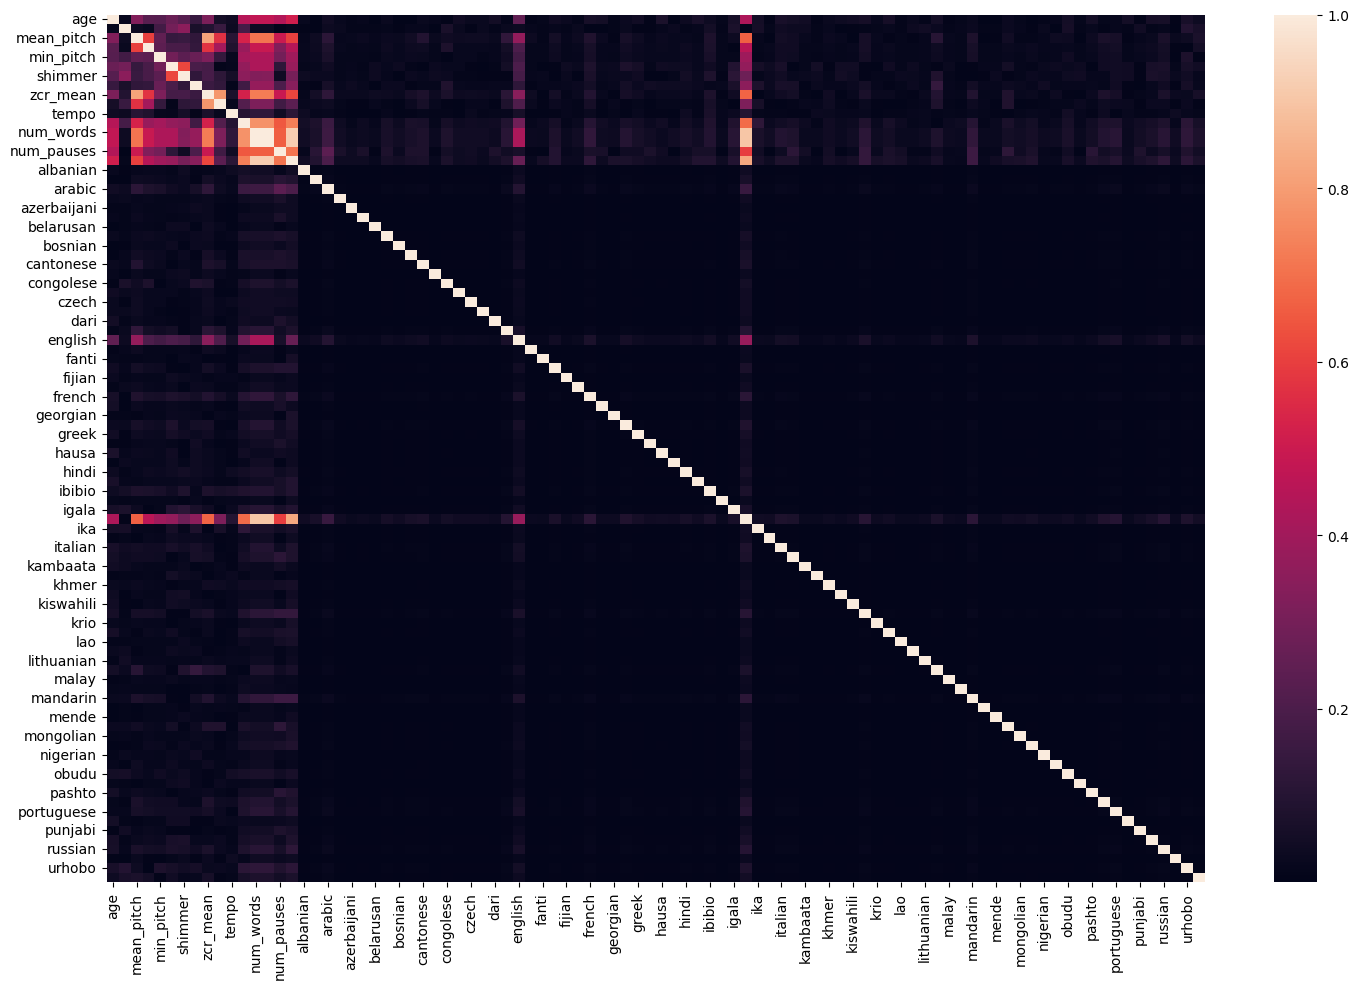

In [44]:
temp:pd.Series = step3_log_dev_df.corr().loc['age', :].sort_values(ascending=False)
display(temp.head(10))
display(temp.tail(10))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
sns.heatmap(np.abs(step3_log_dev_df.corr()), ax=ax)
plt.tight_layout()

### Standardization

In [48]:
#TODO: only one scaler fitted on dev?

no_age_dev_df = step3_log_dev_df.drop(columns=['age'], axis=1)

scaler = StandardScaler().fit(no_age_dev_df)

step3_log_norm_dev_df = pd.DataFrame(scaler.transform(no_age_dev_df), columns=no_age_dev_df.columns)
step3_log_norm_eval_df = pd.DataFrame(scaler.transform(step3_log_eval_df), columns=step3_log_eval_df.columns)

display(step3_log_norm_dev_df.head())
display(step3_log_norm_eval_df.head())

,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,...,pashto,polish,portuguese,pulaar,punjabi,romanian,russian,tiv,urhobo,yoruba
0,-0.998978,1.295444,0.413221,-0.400362,-1.298379,-0.853814,-0.404445,1.534388,1.416622,0.796088,...,-0.058491,-0.108297,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095
1,-0.998978,0.406357,0.411611,-0.415793,0.754143,-0.288687,0.855523,-0.277067,-0.777731,0.121675,...,-0.058491,-0.108297,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095
2,-0.998978,0.476199,0.411505,-0.402148,-0.206386,0.518159,-0.123477,0.258771,0.739585,-0.225751,...,-0.058491,-0.108297,7.752688,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095
3,-0.998978,0.661310,0.410845,0.278367,-0.592809,-0.057508,1.920345,1.182793,1.593684,-0.225751,...,-0.058491,-0.108297,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095
4,1.001023,1.096713,0.411146,-0.395821,1.093041,0.682511,0.474725,0.292051,-0.295562,-0.376805,...,-0.058491,-0.108297,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,...,pashto,polish,portuguese,pulaar,punjabi,romanian,russian,tiv,urhobo,yoruba
0,1.001023,-0.132027,0.310818,-0.411849,0.288722,1.859285,-0.069907,-1.889152,-1.084587,-1.311455,...,-0.058491,-0.108297,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095
1,1.001023,0.269560,0.412198,-0.364788,0.913004,0.907538,0.711640,0.558209,0.401067,-1.064363,...,-0.058491,-0.108297,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095
2,1.001023,-0.388885,-0.627155,-0.335666,-0.392564,-0.286866,0.291060,-0.050143,-0.279479,-0.060310,...,-0.058491,-0.108297,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095
3,-0.998978,0.598590,0.411678,-0.405267,1.003108,-0.584964,1.508214,0.106896,-0.484025,-0.060310,...,-0.058491,-0.108297,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095
4,1.001023,1.010125,0.413308,-0.418335,0.217608,-0.004417,-0.909264,0.796607,0.680233,-0.376805,...,-0.058491,-0.108297,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095


## Error plot

In [25]:
def plot_error_distripution(y_pred, y_val, precision):
    errors = pd.DataFrame(np.round(y_pred.flatten() - y_val.values.flatten(), precision), columns=['error'])
    error_counts = errors['error'].value_counts().reset_index()
    error_counts.columns = ['error', 'count']

    plt.figure()
    plt.scatter(error_counts['error'], error_counts['count'])
    plt.xlabel('Error')
    plt.ylabel('Count')
    plt.title('Distribution of Prediction Errors')
    plt.show()
    return error_counts

In [21]:
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import cross_val_score

# cross_val_score(make_pipeline(StandardScaler(), RandomForestRegressor()), step3_log_dev_df, ages_df, cv=15, scoring='neq_mean_squared_error').mean().abs()

## First regressor

10.561827501448684

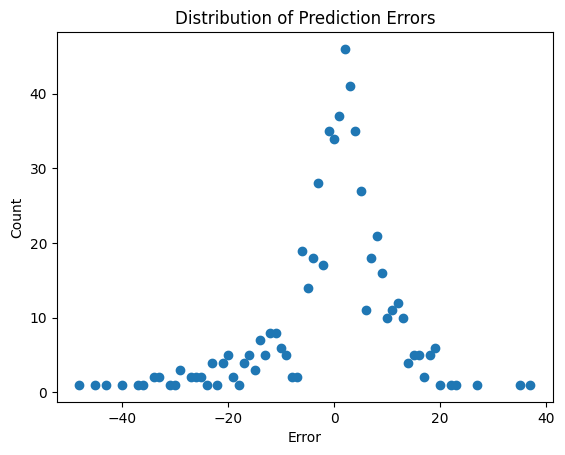

In [49]:
X_train_val_df = step3_log_norm_dev_df.copy()
X_train_val_df = X_train_val_df

forest = RandomForestRegressor(random_state=341967)

X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred, y_val, 0)
#10.455056281368881

First look to feature importances

In [50]:
sorted(zip(forest.feature_names_in_, forest.feature_importances_), key=lambda x:x[1] , reverse=True)

[('silence_duration', np.float64(0.33606309846647864)),
 ('hnr', np.float64(0.06455290777030127)),
 ('jitter', np.float64(0.06157298872684104)),
 ('num_pauses', np.float64(0.05875485939243125)),
 ('spectral_centroid_mean', np.float64(0.05271176834520946)),
 ('energy', np.float64(0.05268965720213534)),
 ('mean_pitch', np.float64(0.05257699811898363)),
 ('min_pitch', np.float64(0.05084850390464688)),
 ('shimmer', np.float64(0.049624002615041525)),
 ('max_pitch', np.float64(0.04879966013731428)),
 ('zcr_mean', np.float64(0.04204108173760822)),
 ('english', np.float64(0.037648353081898414)),
 ('tempo', np.float64(0.0361684645535564)),
 ('gender', np.float64(0.008068789467810592)),
 ('greek', np.float64(0.0037516987935891904)),
 ('polish', np.float64(0.003030480994038496)),
 ('italian', np.float64(0.002371993674240343)),
 ('croatian', np.float64(0.002239546589259856)),
 ('congolese', np.float64(0.0020490651913900293)),
 ('japanese', np.float64(0.0020194509064983155)),
 ('num_words', np.floa

As we can see, only ethnicity "english" seems to give a significant contribution to regressor

In [51]:
step3_log_norm_eval_df.head()

,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,...,pashto,polish,portuguese,pulaar,punjabi,romanian,russian,tiv,urhobo,yoruba
0,1.001023,-0.132027,0.310818,-0.411849,0.288722,1.859285,-0.069907,-1.889152,-1.084587,-1.311455,...,-0.058491,-0.108297,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095
1,1.001023,0.269560,0.412198,-0.364788,0.913004,0.907538,0.711640,0.558209,0.401067,-1.064363,...,-0.058491,-0.108297,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095
2,1.001023,-0.388885,-0.627155,-0.335666,-0.392564,-0.286866,0.291060,-0.050143,-0.279479,-0.060310,...,-0.058491,-0.108297,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095
3,-0.998978,0.598590,0.411678,-0.405267,1.003108,-0.584964,1.508214,0.106896,-0.484025,-0.060310,...,-0.058491,-0.108297,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095
4,1.001023,1.010125,0.413308,-0.418335,0.217608,-0.004417,-0.909264,0.796607,0.680233,-0.376805,...,-0.058491,-0.108297,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095


In [52]:
y_eval_pred = forest.predict(X_train_val_df.values)

display(np.max(y_eval_pred), np.min(y_eval_pred))
display(np.max(ages_df), np.min(ages_df))

np.float64(79.61)

np.float64(15.94)

np.float64(97.0)

np.float64(6.0)

In [26]:
abs(
    cross_val_score(
        RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=341967), 
        X_train_val_df, 
        ages_df, cv=10, 
        scoring='neg_root_mean_squared_error', 
        n_jobs=-1
    ).mean()
)

# abs(
#     croscross_val_score(
#         make_pipeline(StandardScaler(), RandomForestRegressor()), 
#         X_train_val_df, 
#         ages_df, cv=10, 
#         scoring='neg_root_mean_squared_error', 
#         n_jobs=-1
#     ).mean()
# )

10.56155197642154

## Fine tuned

10.510100343820502

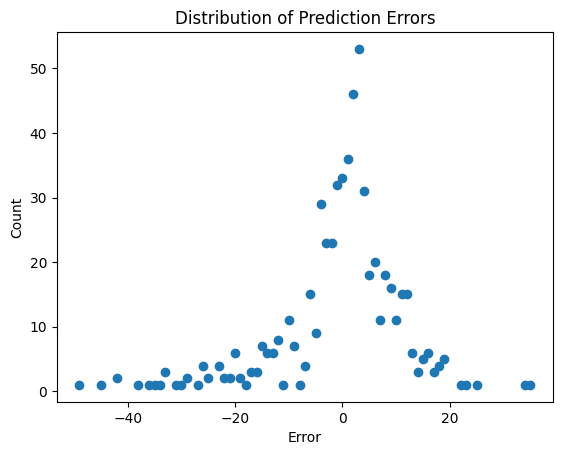

In [27]:
# def grid(builder, configs, cv):
#     gs = GridSearchCV(builder(), configs, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv)
#     gs.fit(X_train.values, y_train.values.reshape((-1,)))
    
#     return gs

# X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

# best = grid(RandomForestRegressor, {'n_estimators': [300, 500], 'random_state': [341967]}, 5)

# y_pred = best.predict(X_val.values)

# display(root_mean_squared_error(y_val, y_pred))
# _ = plot_error_distripution(y_pred, y_val, 0)

#10.424189101247185

## Preprocess audio

### Data exploration

In [28]:
def plot_audio(y:np.ndarray, sr:float, time=False, freq=False, spectrogram=False, mel=False, mfcc=False, hp=False, poly=False,plot=True):
    """
        Returns the thing plotted\n
        If freq = True, returns the frequencies used too\n
        If hp=True, returns Harmonic and Percussion\n
        If all False, returns y
    """

    if time:
        if plot:
            plt.figure(figsize=(12, 3))
            plt.title(f"Audio {i} as waveform")
            librosa.display.waveshow(y, sr=sr)

        return y
    if freq:
        y_freq = np.abs(scipy.fft.fft(y))
        f = np.linspace(0, sr, len(y_freq))
        
        if plot:
            plt.figure(figsize=(12, 3))
            plt.title(f"Spectrum of audio {i}")
            plt.semilogx(f[: len(f) // 2], y_freq[: len(f) // 2])
            plt.xlabel("Frequency (Hz)")

        return y_freq, f
    if spectrogram:
        y_stft = np.abs(librosa.stft(y))
        y_stft_db = librosa.amplitude_to_db(y_stft, ref=np.max)
        
        if plot:
            plt.figure(figsize=(12, 4))
            plt.title(f"Spectrogram of audio {i}")
            librosa.display.specshow(y_stft_db, sr=sr, x_axis="time", y_axis="log")
            plt.colorbar(format="%.1f dB")

        return y_stft
    if mel:
        y_mel = librosa.feature.melspectrogram(y=y, sr=sr)
        y_mel_db = librosa.power_to_db(y_mel, ref=np.max)

        if plot:
            plt.figure(figsize=(12, 4))
            plt.title(f"Mel-spectrogram of audio {i}")
            librosa.display.specshow(y_mel_db, sr=sr, x_axis="time", y_axis="mel")
            plt.colorbar(format="%.2f dB")
        
        return y_mel, y_mel_db
    if mfcc:
        y_mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        
        if plot:
            plt.figure(figsize=(12, 4))
            plt.title(f"MFCC of audio {i}")
            librosa.display.specshow(y_mfccs, sr=sr, x_axis="time")
            plt.colorbar()

        return y_mfccs
    if hp:
        y_stft = librosa.stft(y)
        H, P = librosa.decompose.hpss(y_stft)
        Hmag = np.abs(H)
        Pmag = np.abs(P)

        if plot:
            Hdb = librosa.amplitude_to_db(Hmag, ref=np.max)
            Pdb = librosa.amplitude_to_db(Pmag, ref=np.max)
            
            plt.figure(figsize=(12, 4))
            plt.title(f"Harmonic source of audio {i}")
            librosa.display.specshow(Hdb, sr=sr, x_axis="time", y_axis="log")
            plt.colorbar(format="%.2f dB")

            plt.figure(figsize=(12, 4))
            plt.title(f"Percussive source of audio {i}")
            librosa.display.specshow(Pdb, sr=sr, x_axis="time", y_axis="log")
            plt.colorbar(format="%.2f dB")

        return librosa.istft(H), Hmag, librosa.istft(P), Pmag
    if poly:
        y_poly = librosa.feature.poly_features(y=y, sr=sr)

        if plot:
            plt.figure(figsize=(12, 8))
            plt.title(f"Polynomial feature of audio {i}")
            plt.plot(y_poly[0], label="Coeffs order 0")
            plt.plot(y_poly[1], label="Coeffs order 1")
            plt.legend()

        return y_poly
    plt.show()

    return y

In [29]:
test_audios = np.random.choice(audio_dev, 3)

#### Time domain

In [30]:
def time_domain(audios, plot=False):
    res = pd.DataFrame(0, index=audios, columns=['audio_length'], dtype=float)
    for i in audios:
        y, sr = librosa.load(AUDIOS_DEVELOPMENT + i, sr=sampling_rate)
        zcr = y.shape[0]/sr

        res.loc[i] = zcr

        if plot:
            plot_audio(y, sr, time=True, plot=plot)

            print(f"Audio: {i}")
            print(f"Length: {zcr}")
    return res

time_domain(test_audios)

,audio_length
1610.wav,30.209161
2147.wav,28.268390
711.wav,1.175102


#### Frequency domain

In [31]:
def freq_domain(audios, plot=False):
    res = pd.DataFrame(0, index=audios, columns=['dominant_frequency', 'highest_freq_in_spectrum', 'lowest_freq_in_spectrum', 'spectrum_wide'], dtype=float)

    for i in audios:
        y, sr = librosa.load(AUDIOS_DEVELOPMENT + i, sr=sampling_rate)

        y_freq, f = plot_audio(y, sr, freq=True, plot=plot)

        y_mag = np.abs(y_freq)
        dominant_frequency = f[np.argmax(y_mag)]

        threshold = np.max(y_mag) * 0.1
        significant_freqs = f[y_mag > threshold]

        if len(significant_freqs) > 0:
            lowest_freq_in_spectrum, highest_freq_in_spectrum = significant_freqs[0], significant_freqs[-1]
        else:
            lowest_freq_in_spectrum, highest_freq_in_spectrum = 0, 0

        spectrum_wide = highest_freq_in_spectrum - lowest_freq_in_spectrum
        res.loc[i, 'dominant_frequency'] = dominant_frequency
        res.loc[i, 'lowest_freq_in_spectrum'] = lowest_freq_in_spectrum
        res.loc[i, 'highest_freq_in_spectrum'] = highest_freq_in_spectrum
        res.loc[i, 'spectrum_wide'] = spectrum_wide

        if plot:
            print(f"Audio: {i}")
            print(f"Dominant frequency: {dominant_frequency}")

            print(f"Lowest important freq:{lowest_freq_in_spectrum}")
            print(f"Highest important freq:{highest_freq_in_spectrum}")
            print(f"Length of spectrum: {highest_freq_in_spectrum - lowest_freq_in_spectrum}\n")

    return res

freq_domain(test_audios)

,dominant_frequency,highest_freq_in_spectrum,lowest_freq_in_spectrum,spectrum_wide
1610.wav,233.505677,22050.000000,0.033103,22049.966897
2147.wav,115.747846,22048.761866,1.273509,22047.488357
711.wav,0.000000,22044.893863,0.000000,22044.893863


#### Spectrogram

In [32]:
def spectrogram(audios, plot=False):
    res = pd.DataFrame(0, index=audios, columns=['spect_overall_mean', 'spect_overall_var'], dtype=float)

    for i in audios:
        y, sr = librosa.load(AUDIOS_DEVELOPMENT + i, sr=sampling_rate)

        S= plot_audio(y, sr, spectrogram=True, plot=plot)

        temporal_mean = S.mean(axis=1)
        temporal_variance = S.var(axis=1)
        temporal_skewness = skew(S, axis=1)
        temporal_kurtosis = kurtosis(S, axis=1)

        frequency_mean = S.mean(axis=0)
        frequency_variance = S.var(axis=0)
        frequency_skewness = skew(S, axis=0)
        frequency_kurtosis = kurtosis(S, axis=0)

        spect_overall_mean = S.mean()
        spect_overall_var = S.var()

        res.loc[i, 'spect_overall_mean'] = spect_overall_mean
        res.loc[i, 'spect_overall_var'] = spect_overall_var

        if plot:
            print(f"Audio: {i}")
            print(f"Temporal mean:\n{temporal_mean}")
            print(f"Temporal variance:\n{temporal_variance}")
            print(f"Temporal skewness:\n{temporal_skewness}")
            print(f"Temporal kurtosis:\n{temporal_kurtosis}")
            
            print(f"Overall mean:\n{S.mean()}")
            print(f"Overall variance:\n{S.var()}")
            
            print(f"Frequency mean:\n{frequency_mean}")
            print(f"Frequency variance:\n{frequency_variance}")
            print(f"Frequency skewness:\n{frequency_skewness}")
            print(f"Frequency kurtosis:\n{frequency_kurtosis}")

            display(temporal_mean.shape)    

    return res

spectrogram(test_audios)

,spect_overall_mean,spect_overall_var
1610.wav,0.402391,4.277882
2147.wav,0.344299,2.652717
711.wav,0.129705,0.572112


#### Mel-spectrogram

In [33]:
def mel_spectrogram(audios, plot=False):
    res = pd.DataFrame(0, index=audios, columns=['mel_overall_mean', 'mel_overall_var'], dtype=float)
    for i in audios:
        y, sr = librosa.load(AUDIOS_DEVELOPMENT + i, sr=sampling_rate)

        S, S_db = plot_audio(y, sr, mel=True, plot=plot)

        temporal_mean = S.mean(axis=1)
        temporal_variance = S.var(axis=1)
        temporal_skewness = skew(S, axis=1)
        temporal_kurtosis = kurtosis(S, axis=1)

        frequency_mean = S.mean(axis=0)
        frequency_variance = S.var(axis=0)
        frequency_skewness = skew(S, axis=0)
        frequency_kurtosis = kurtosis(S, axis=0)
        
        overall_mean = S.mean()
        overall_var = S.var()

        res.loc[i, 'mel_overall_mean'] = overall_mean
        res.loc[i, 'mel_overall_var'] = overall_var

        if plot:
            print(f"Audio: {i}")
            print(f"Temporal mean:\n{temporal_mean}")
            print(f"Temporal variance:\n{temporal_variance}")
            print(f"Temporal skewness:\n{temporal_skewness}")
            print(f"Temporal kurtosis:\n{temporal_kurtosis}")

            print(f"Overall mean:\n{overall_mean}")
            print(f"Overall variance:\n{overall_var}")

            print(f"Frequency mean:\n{frequency_mean}")
            print(f"Frequency variance:\n{frequency_variance}")
            print(f"Frequency skewness:\n{frequency_skewness}")
            print(f"Frequency kurtosis:\n{frequency_kurtosis}")
            display('')

    return res

mel_spectrogram(test_audios)

,mel_overall_mean,mel_overall_var
1610.wav,1.16498,308.290314
2147.wav,0.78592,36.537331
711.wav,0.16626,2.883223


#### Mel-frequency cepstral coefficients (MFCC)

In [34]:
def mfcc(audios, plot=False):
    res = pd.DataFrame(0, index=audios, columns=['mfcc_overall_mean', 'mfcc_overall_var'], dtype=float)
    for i in audios:
        y, sr = librosa.load(AUDIOS_DEVELOPMENT + i, sr=sampling_rate)

        S = plot_audio(y, sr, mfcc=True, plot=plot)

        temporal_mean = S.mean(axis=1)
        temporal_variance = S.var(axis=1)
        temporal_skewness = skew(S, axis=1)
        temporal_kurtosis = kurtosis(S, axis=1)

        frequency_mean = S.mean(axis=0)
        frequency_variance = S.var(axis=0)
        frequency_skewness = skew(S, axis=0)
        frequency_kurtosis = kurtosis(S, axis=0)

        # print(temporal_mean)

        overall_mean = S.mean()
        overall_var = S.var()

        res.loc[i, 'mfcc_overall_mean'] = overall_mean
        res.loc[i, 'mfcc_overall_var'] = overall_var

        if plot:
            print(f"Audio: {i}")
            print(f"Temporal mean:\n{temporal_mean}")
            print(f"Temporal variance:\n{temporal_variance}")
            print(f"Temporal skewness:\n{temporal_skewness}")
            print(f"Temporal kurtosis:\n{temporal_kurtosis}")
            
            print(f"Overall mean:\n{overall_mean}")
            print(f"Overall variance:\n{overall_var}")
            
            print(f"Frequency mean:\n{frequency_mean}")
            print(f"Frequency variance:\n{frequency_variance}")
            print(f"Frequency skewness:\n{frequency_skewness}")
            print(f"Frequency kurtosis:\n{frequency_kurtosis}")
        
            display("")
    return res

mfcc(test_audios)

,mfcc_overall_mean,mfcc_overall_var
1610.wav,-9.235680,4629.597168
2147.wav,-7.192048,7232.896484
711.wav,-7.723734,8239.830078


#### Harmonic-percussive source separation

In [35]:
def hpss(audios, plot=False):
    res = pd.DataFrame(0, index=audios, columns=['harmonic_overall_mean', 'harmonic_overall_var', 'percussion_overall_mean', 'percussion_overall_var'], dtype=float)
    
    for i in audios:
        y, sr = librosa.load(AUDIOS_DEVELOPMENT + i, sr=sampling_rate)

        h, Hmag, p, Pmag = plot_audio(y, sr, hp=True, plot=plot)

        temporal_mean_h     = Hmag.mean(axis=1)
        temporal_variance_h = Hmag.var(axis=1)
        temporal_skewness_h = skew(Hmag, axis=1)
        temporal_kurtosis_h = kurtosis(Hmag, axis=1)

        temporal_mean_p =     Pmag.mean(axis=1)
        temporal_variance_p = Pmag.var(axis=1)
        temporal_skewness_p = skew(Pmag, axis=1)
        temporal_kurtosis_p = kurtosis(Pmag, axis=1)

        harmonic_overall_mean = Hmag.mean()
        harmonic_overall_var = Hmag.var()

        percussion_overall_mean = Pmag.mean()
        percussion_overall_var = Pmag.var()

        res.loc[i, 'harmonic_overall_mean'] = harmonic_overall_mean
        res.loc[i, 'harmonic_overall_var'] = harmonic_overall_var        
        res.loc[i, 'percussion_overall_mean'] = percussion_overall_mean
        res.loc[i, 'percussion_overall_var'] = percussion_overall_var
    
        if plot:
            print(f"Temporal mean for harmonic source:    \n{temporal_mean_h}")
            print(f"Temporal variance for harmonic source:\n{temporal_variance_h}")
            print(f"Temporal skewness for harmonic source:\n{temporal_skewness_h}")
            print(f"Temporal kurtosis for harmonic source:\n{temporal_kurtosis_h}")
            
            print(f"Temporal mean for percussion source:    \n{temporal_mean_p}")
            print(f"Temporal variance for percussion source:\n{temporal_variance_p}")
            print(f"Temporal skewness for percussion source:\n{temporal_skewness_p}")
            print(f"Temporal kurtosis for percussion source:\n{temporal_kurtosis_p}")

            print(f"Overall mean for harmonic source:\n{harmonic_overall_mean}")
            print(f"Overall variance for harmonic source:\n{harmonic_overall_var}")
            print(f"Overall mean for percussion source:\n{percussion_overall_mean}")
            print(f"Overall variance for percussion source:\n{percussion_overall_var}")

            display("")
            
            plot_audio(h, sr, mfcc=True, plot=plot)
            plot_audio(p, sr, mfcc=True, plot=plot)

    return res

hpss(test_audios)

,harmonic_overall_mean,harmonic_overall_var,percussion_overall_mean,percussion_overall_var
1610.wav,0.138677,1.836991,0.263714,1.682325
2147.wav,0.088877,0.772474,0.255422,1.377367
711.wav,0.045254,0.101098,0.084451,0.369114


#### Zero-crossing rate

In [36]:
def zcr(audios, plot=False):
    res = pd.DataFrame(0, index=audios, columns=['zcr'], dtype=float)
    
    for i in audios:
        y, sr = librosa.load(AUDIOS_DEVELOPMENT + i, sr=sampling_rate)

        zero_astfly = librosa.zero_crossings(y, pad=False).sum()
        zcr_ = float(zero_astfly/(y.shape[0]/sr))

        res.loc[i, 'zcr'] = zcr_

        if plot:
            display(zcr_)

    return res

zcr(test_audios, plot=False)


,zcr
1610.wav,3253.019838
2147.wav,1700.132196
711.wav,799.079542


#### Polyfeatures

In [37]:
def poly(audios, plot=False):
    res = pd.DataFrame(0, index=audios, columns=['mean_coeffs', 'std_coeffs'], dtype=float)
    
    for i in audios:
        y, sr = librosa.load(AUDIOS_DEVELOPMENT + i, sr=sampling_rate)

        y_poly = plot_audio(y, sr, poly=True, plot=plot)

        res.loc[i, 'mean_coeffs'] = y_poly[1].mean()
        res.loc[i, 'std_coeffs'] = y_poly[1].std()

    return res

poly(test_audios, plot=False)

,mean_coeffs,std_coeffs
1610.wav,0.919163,0.880853
2147.wav,1.002769,0.974155
711.wav,0.395523,0.300787


In [38]:
def extract_all_features(audios, plot=False):
    # extract features

    time = time_domain(audios, plot)
    freq = freq_domain(audios, plot)
    spec = spectrogram(audios, plot)
    mel = mel_spectrogram(audios, plot)
    mfccs = mfcc(audios, plot)
    hp = hpss(audios, plot)
    zcrs = zcr(audios, plot)
    poly_feats = poly(audios, plot)

    # make unique dataframe
    features = pd.concat([time, freq, spec, mel, mfccs, hp, zcrs, poly_feats], axis=1)
    features.index.name = 'audio'

    return features   

In [54]:
COMPUTE_ALL = False

if COMPUTE_ALL:
    features_extracted_dev = extract_all_features(audio_dev)
    features_extracted_dev.to_csv('dev_features_extracted.csv')
else:
    features_extracted_dev = pd.read_csv('dev_features_extracted.csv', header=0)

In [55]:
if False:
    features_extracted_eval = extract_all_features(audio_eval)
    features_extracted_eval.to_csv('eval_features_extracted.csv')
else:
    features_extracted_eval = pd.read_csv('eval_features_extracted.csv', header=0)

In [56]:
audio_dev[:5]

display(features_extracted_dev)

,audio,audio_length,dominant_frequency,highest_freq_in_spectrum,lowest_freq_in_spectrum,spectrum_wide,spect_overall_mean,spect_overall_var,mel_overall_mean,mel_overall_var,mfcc_overall_mean,mfcc_overall_var,harmonic_overall_mean,harmonic_overall_var,percussion_overall_mean,percussion_overall_var,zcr,mean_coeffs,std_coeffs
0,1.wav,35.095238,516.053584,21873.052689,176.975805,21696.076883,0.246090,1.668016,0.461432,36.497124,-24.823318,7667.960938,0.058879,0.432257,0.187211,0.934653,4637.694708,0.625073,0.827329
1,2.wav,23.331293,204.489711,22007.824801,42.218060,21965.606740,0.384329,5.852709,1.806124,312.843323,-9.239993,5664.231445,0.156535,3.316745,0.227794,1.621247,1741.009418,1.241265,1.165380
2,3.wav,21.667891,59.996735,22044.646445,5.399706,22039.246739,0.298451,2.203201,0.655626,50.915668,-7.419178,5551.500000,0.111952,1.104374,0.186499,0.781319,2326.853113,0.750849,0.675249
3,4.wav,22.476961,230.325191,21871.194332,178.850158,21692.344174,0.842808,16.436279,4.854883,2951.604004,-16.265335,4622.220215,0.282192,9.203614,0.560616,4.570867,3836.417133,1.826079,1.661038
4,5.wav,19.090295,101.884473,22043.661686,6.390697,22037.270989,0.427518,3.934452,1.181639,91.762680,-5.412870,5290.830078,0.131971,1.378028,0.295547,1.742151,2369.476245,1.245798,0.935781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,2929.wav,20.410748,128.951953,22047.256341,2.792652,22044.463689,0.298188,1.353628,0.400953,8.777692,-8.413234,5972.022461,0.079865,0.380205,0.218323,0.733674,2470.904019,0.829058,0.687453
2929,2930.wav,1.509206,0.000000,22042.048562,0.000000,22042.048562,0.136532,0.244674,0.072874,0.246325,-9.356692,6027.036133,0.063762,0.114501,0.072770,0.093980,1577.650400,0.366185,0.251601
2930,2931.wav,1.645034,50.456275,22044.528838,0.000000,22044.528838,0.194900,1.085961,0.329160,10.671579,-8.080606,7173.562500,0.083764,0.538602,0.111136,0.300148,1298.453395,0.558290,0.483551
2931,2932.wav,20.708163,440.068964,21927.535949,122.512341,21805.023609,0.284262,3.333555,1.030522,132.280411,-16.765680,6838.713867,0.109032,1.503631,0.175230,1.091356,2544.069183,0.918632,0.818483


### Join of data

In [61]:
# features_extracted_dev = features_extracted_dev.drop(columns=['audio'], axis=1)

step4_dev_df = pd.concat([no_age_dev_df, features_extracted_dev.drop(columns=['audio'], axis=1)], axis=1)
step4_eval_df = pd.concat([step3_log_eval_df, features_extracted_eval.drop(columns=['audio'], axis=1)], axis=1)

# step4_df['word_per_second'] = step4_df['num_words'] / step4_df['audio_length']

display(step4_dev_df.head())
display(step4_eval_df.head())

,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,...,mel_overall_var,mfcc_overall_mean,mfcc_overall_var,harmonic_overall_mean,harmonic_overall_var,percussion_overall_mean,percussion_overall_var,zcr,mean_coeffs,std_coeffs
0,-1.0,3.260475,3999.7170,145.43066,-1.860294,-1.082361,-2.647084,-0.677588,3.493075,151.999081,...,36.497124,-24.823318,7667.960938,0.058879,0.432257,0.187211,0.934653,4637.694708,0.625073,0.827329
1,-1.0,3.113214,3998.8590,145.37268,-1.596048,-1.016633,-2.106869,-1.103202,3.227377,129.199219,...,312.843323,-9.239993,5664.231445,0.156535,3.316745,0.227794,1.621247,1741.009418,1.241265,1.165380
2,-1.0,3.124782,3998.8025,145.42395,-1.719708,-0.922792,-2.526618,-0.977303,3.411098,117.453835,...,50.915668,-7.419178,5551.500000,0.111952,1.104374,0.186499,0.781319,2326.853113,0.750849,0.675249
3,-1.0,3.155442,3998.4510,147.98083,-1.769457,-0.989746,-1.650323,-0.760197,3.514515,117.453835,...,2951.604004,-16.265335,4622.220215,0.282192,9.203614,0.560616,4.570867,3836.417133,1.826079,1.661038
4,1.0,3.227559,3998.6113,145.44772,-1.552417,-0.903676,-2.270137,-0.969483,3.285759,112.347147,...,91.762680,-5.412870,5290.830078,0.131971,1.378028,0.295547,1.742151,2369.476245,1.245798,0.935781


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,...,mel_overall_var,mfcc_overall_mean,mfcc_overall_var,harmonic_overall_mean,harmonic_overall_var,percussion_overall_mean,percussion_overall_var,zcr,mean_coeffs,std_coeffs
0,1.0,3.024041,3945.1610,145.38750,-1.655967,-0.766810,-2.503650,-1.481972,3.190222,80.749512,...,36.497124,-24.823318,7667.960938,0.058879,0.432257,0.187211,0.934653,4637.694708,0.625073,0.827329
1,1.0,3.090556,3999.1720,145.56432,-1.575595,-0.877504,-2.168559,-0.906948,3.370109,89.102909,...,312.843292,-9.239995,5664.231445,0.156535,3.316745,0.227794,1.621247,1741.009418,1.241265,1.165380
2,1.0,2.981497,3445.4490,145.67374,-1.743677,-1.016421,-2.348884,-1.049884,3.287707,123.046875,...,50.915668,-7.419178,5551.500000,0.111952,1.104374,0.186499,0.781319,2326.853113,0.750849,0.675249
3,-1.0,3.145054,3998.8948,145.41223,-1.563995,-1.051092,-1.827025,-1.012987,3.262939,123.046875,...,2951.604004,-16.265335,4622.220215,0.282192,9.203614,0.560616,4.570867,3836.417133,1.826079,1.661038
4,1.0,3.213217,3999.7632,145.36313,-1.665122,-0.983571,-2.863526,-0.850934,3.403911,112.347147,...,91.762680,-5.412870,5290.830078,0.131971,1.378028,0.295547,1.742151,2369.476245,1.245798,0.935781


In [62]:
# need standardize data
scaler_join = StandardScaler().fit(step4_dev_df)

step4_dev_norm_df = pd.DataFrame(scaler_join.transform(step4_dev_df), columns=step4_dev_df.columns)
step4_eval_norm_df = pd.DataFrame(scaler_join.transform(step4_eval_df), columns=step4_eval_df.columns)

display(step4_dev_norm_df.head())
display(step4_eval_norm_df.head())

,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,...,mel_overall_var,mfcc_overall_mean,mfcc_overall_var,harmonic_overall_mean,harmonic_overall_var,percussion_overall_mean,percussion_overall_var,zcr,mean_coeffs,std_coeffs
0,-0.998978,1.295444,0.413221,-0.400362,-1.298379,-0.853814,-0.404445,1.534388,1.416622,0.796088,...,-0.289908,-2.990870,0.998604,-0.957505,-0.568174,-0.274808,-0.320622,2.039962,-0.678260,0.003154
1,-0.998978,0.406357,0.411611,-0.415793,0.754143,-0.288687,0.855523,-0.277067,-0.777731,0.121675,...,0.033185,0.231562,-0.265833,0.584296,0.842723,0.035544,0.053574,-0.517137,0.566580,0.813061
2,-0.998978,0.476199,0.411505,-0.402148,-0.206386,0.518159,-0.123477,0.258771,0.739585,-0.225751,...,-0.273051,0.608083,-0.336971,-0.119588,-0.239419,-0.280250,-0.404189,0.000027,-0.424165,-0.361200
3,-0.998978,0.661310,0.410845,0.278367,-0.592809,-0.057508,1.920345,1.182793,1.593684,-0.225751,...,3.118326,-1.221189,-0.923385,2.568175,3.722182,2.580740,1.661126,1.332621,1.748030,2.000562
4,1.001023,1.096713,0.411146,-0.395821,1.093041,0.682511,0.474725,0.292051,-0.295562,-0.376805,...,-0.225294,1.022962,-0.501464,0.196476,-0.105566,0.553674,0.119467,0.037653,0.575739,0.262986


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,...,mel_overall_var,mfcc_overall_mean,mfcc_overall_var,harmonic_overall_mean,harmonic_overall_var,percussion_overall_mean,percussion_overall_var,zcr,mean_coeffs,std_coeffs
0,1.001023,-0.132027,0.310818,-0.411849,0.288722,1.859285,-0.069907,-1.889152,-1.084587,-1.311455,...,-0.289908,-2.990870,0.998604,-0.957505,-0.568174,-0.274808,-0.320622,2.039962,-0.678260,0.003154
1,1.001023,0.269560,0.412198,-0.364788,0.913004,0.907538,0.711640,0.558209,0.401067,-1.064363,...,0.033185,0.231562,-0.265833,0.584296,0.842723,0.035544,0.053574,-0.517137,0.566580,0.813061
2,1.001023,-0.388885,-0.627155,-0.335666,-0.392564,-0.286866,0.291060,-0.050143,-0.279479,-0.060310,...,-0.273051,0.608083,-0.336971,-0.119588,-0.239419,-0.280250,-0.404190,0.000027,-0.424165,-0.361200
3,-0.998978,0.598590,0.411678,-0.405267,1.003108,-0.584964,1.508214,0.106896,-0.484025,-0.060310,...,3.118326,-1.221189,-0.923385,2.568175,3.722182,2.580740,1.661126,1.332621,1.748030,2.000562
4,1.001023,1.010125,0.413308,-0.418335,0.217608,-0.004417,-0.909264,0.796607,0.680233,-0.376805,...,-0.225294,1.022962,-0.501464,0.196476,-0.105566,0.553674,0.119467,0.037653,0.575739,0.262986


10.22907241577765

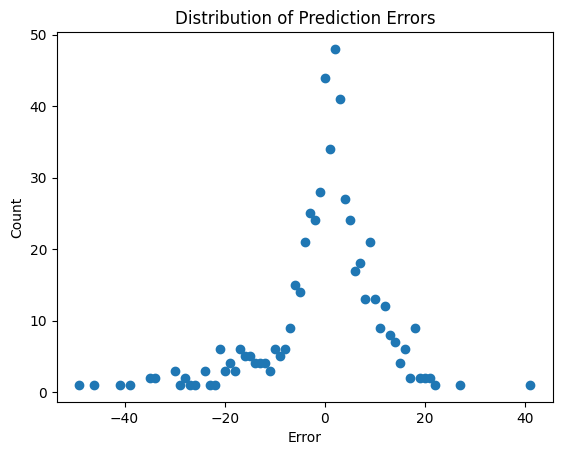

In [63]:
X_train_val_df = step4_dev_norm_df.copy()
X_train_val_df = X_train_val_df

forest = RandomForestRegressor(random_state=341967)

X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred, y_val, 0)
#10.455056281368881

In [64]:
sorted(zip(forest.feature_names_in_, forest.feature_importances_), key=lambda x:x[1] , reverse=True)

[('audio_length', np.float64(0.3171408273762853)),
 ('silence_duration', np.float64(0.053821610099181204)),
 ('english', np.float64(0.04345393628581904)),
 ('jitter', np.float64(0.041577660129052514)),
 ('shimmer', np.float64(0.037291487949202645)),
 ('dominant_frequency', np.float64(0.03583134396929525)),
 ('min_pitch', np.float64(0.032073074846148575)),
 ('spectral_centroid_mean', np.float64(0.030021167500253944)),
 ('mfcc_overall_mean', np.float64(0.02644235953588679)),
 ('mean_pitch', np.float64(0.02547815590497019)),
 ('max_pitch', np.float64(0.025393301068845266)),
 ('hnr', np.float64(0.023887270126140493)),
 ('mfcc_overall_var', np.float64(0.02346916221835225)),
 ('harmonic_overall_var', np.float64(0.021523823470085343)),
 ('num_pauses', np.float64(0.019535485472014082)),
 ('tempo', np.float64(0.019488637888621388)),
 ('mel_overall_var', np.float64(0.01763392430231041)),
 ('percussion_overall_var', np.float64(0.01706421243725993)),
 ('percussion_overall_mean', np.float64(0.01684

# Upload section

In [65]:
y_eval_pred = forest.predict(step4_eval_norm_df)

with open("results.csv", "w") as fout:
    fout.write("Id,Predicted\n")
 
    for id, y in enumerate(y_eval_pred):
        fout.write(f"{id},{y}\n")